# REGRESSION FOR AGE

In [1]:
# Import required libraries for regression, preprocessing, and evaluation
import pandas as pd
import numpy as np
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score,  mean_squared_error
from keras.callbacks import EarlyStopping

In [2]:
model_df = pd.read_csv("not_scaling.csv")
model_df.head()

,hypertension,heart_disease,diabetes,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level
0,0,1,0,0,0,0,80.0,25.19,6.6,140
1,0,0,0,0,0,1,54.0,27.32,6.6,80
2,0,0,0,0,1,0,28.0,27.32,5.7,158
3,0,0,0,0,0,2,36.0,23.45,5.0,155
4,1,1,0,0,1,2,76.0,20.14,4.8,155


In [3]:
# Define target column and separate continuous, binary, and categorical features
target_cols     = ['age']
continuous_cols = ['bmi', 'blood_glucose_level', 'HbA1c_level']
binary_cols     = ['hypertension', 'heart_disease', 'diabetes', 'gender', 'problematic']
categorical_cols= ['smoking_history'] 

In [4]:
X = model_df[continuous_cols + binary_cols + categorical_cols]
y = model_df[target_cols]

In [5]:
# Split dataset into train and test sets (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=None 
)

In [6]:
# Scale continuous features using MinMaxScaler (-1, 1)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_train_cont_scaled = scaler_X.fit_transform(X_train[continuous_cols])
X_test_cont_scaled  = scaler_X.transform(X_test[continuous_cols])

X_train_cont_df = pd.DataFrame(X_train_cont_scaled, index=X_train.index, columns=continuous_cols)
X_test_cont_df  = pd.DataFrame(X_test_cont_scaled,  index=X_test.index,  columns=continuous_cols)

# Keep binary features as they are (no scaling needed)
X_train_bin_df = X_train[binary_cols].copy()
X_test_bin_df  = X_test[binary_cols].copy()

# Apply One-Hot Encoding to categorical feature
ohe = OneHotEncoder(sparse_output=False)
X_train_smoke = ohe.fit_transform(X_train[categorical_cols])
X_test_smoke  = ohe.transform(X_test[categorical_cols])

smoke_cols = ohe.get_feature_names_out(categorical_cols)
X_train_smoke_df = pd.DataFrame(X_train_smoke, index=X_train.index, columns=smoke_cols)
X_test_smoke_df  = pd.DataFrame(X_test_smoke,  index=X_test.index,  columns=smoke_cols)

# Combine continuous, binary, and categorical features into final training and test sets
X_train_final_df = pd.concat([X_train_cont_df, X_train_bin_df, X_train_smoke_df], axis=1)
X_test_final_df  = pd.concat([X_test_cont_df,  X_test_bin_df,  X_test_smoke_df],  axis=1)

X_train_final = X_train_final_df.values
X_test_final  = X_test_final_df.values

# Scale the target variable (age) to the range (-1, 1)
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

In [7]:
# Build neural network model for regression
model = Sequential([
    Dense(256, activation='tanh', input_shape=(X_train_final.shape[1],)),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(1)
])

# Compile the model with Adam optimizer and Mean Squared Error loss
# Metric: Mean Absolute Error (MAE)
model.compile(optimizer="Adam", loss='mean_squared_error', metrics=['mae'])
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20)
]


history = model.fit(
    X_test_final, y_train_scaled,
    epochs=200,  
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-25 20:38:09.244507: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-25 20:38:09.244648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-25 20:38:09.244654: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-25 20:38:09.245182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-25 20:38:09.245191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:27

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,609 (205.50 KB)

 Trainable params: 52,609 (205.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-08-25 20:38:09.821779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3280 - mae: 0.4807 - val_loss: 0.3291 - val_mae: 0.4862
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3175 - mae: 0.4756 - val_loss: 0.3279 - val_mae: 0.4851
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3099 - mae: 0.4682 - val_loss: 0.3225 - val_mae: 0.4831
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3119 - mae: 0.4697 - val_loss: 0.3259 - val_mae: 0.4852
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3116 - mae: 0.4712 - val_loss: 0.3236 - val_mae: 0.4822
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3095 - mae: 0.4679 - val_loss: 0.3227 - val_mae: 0.4824
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3085 - mae: 0.4678 - val_loss: 0.3269 - val_mae: 0.4835
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3108 - mae: 0.4708 - val_loss: 0.3222 - val_mae: 0.4810
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3149 - mae: 0.

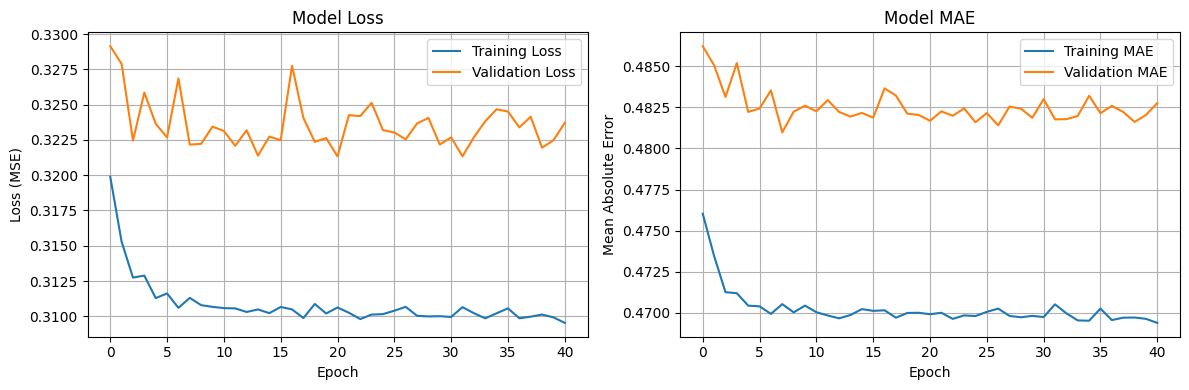

Final Training Loss: 0.3095
Final Validation Loss: 0.3237
Final Training MAE: 0.4694
Final Validation MAE: 0.4828


In [8]:
# Plot training curves (Loss and MAE)
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# MAE plot  
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")

R^2 = -0.001, MSE = 512.877


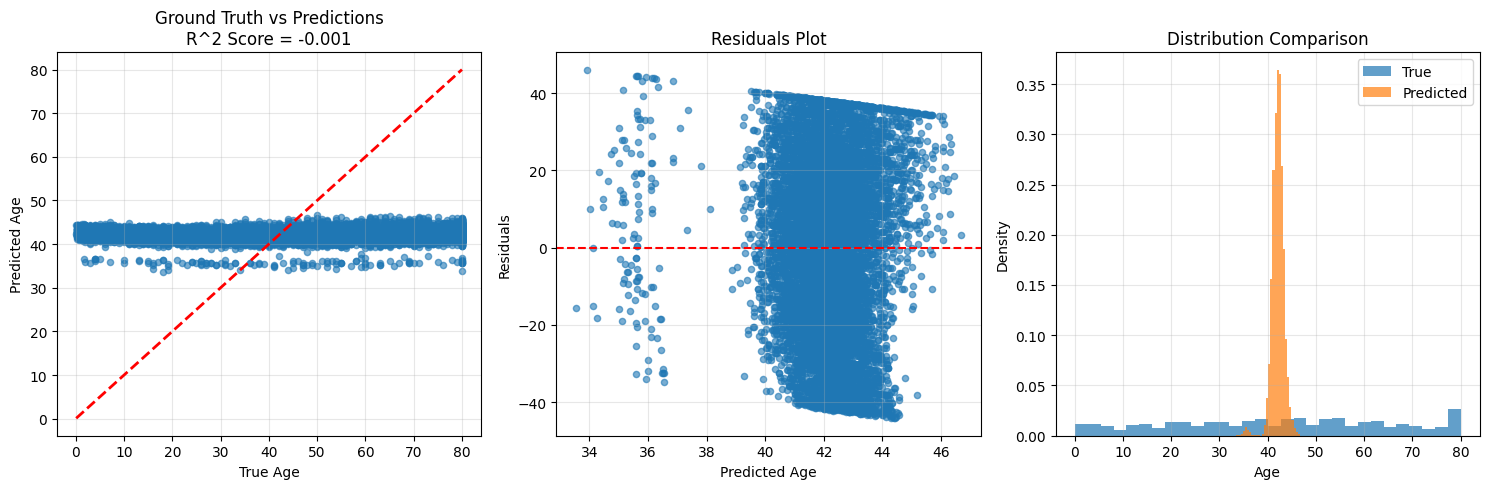

In [9]:
# Evaluate model performance
y_pred_scaled = model.predict(X_test_final, verbose=0)
y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Compute metrics
r2 = r2_score(y_test_original, y_pred_orig)
mse = mean_squared_error(y_test_original, y_pred_orig)

results = {'activation': {'R^2 Score': r2, 'MSE': mse}}  
print(f"R^2 = {r2:.3f}, MSE = {mse:.3f}")

# Visualization: Ground truth vs Predictions, Residuals, and Distribution Comparison
plt.figure(figsize=(15, 5))

# 1. Ground Truth 
plt.subplot(1, 3, 1)
plt.scatter(y_test_original, y_pred_orig, alpha=0.6, s=20)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title(f'Ground Truth vs Predictions\nR^2 Score = {r2:.3f}')
plt.grid(True, alpha=0.3)

# 2. Residuals Plot
plt.subplot(1, 3, 2)
residuals = y_test_original - y_pred_orig
plt.scatter(y_pred_orig, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Age')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# 3. Distribution Comparison
plt.subplot(1, 3, 3)
plt.hist(y_test_original, bins=30, alpha=0.7, label='True', density=True)
plt.hist(y_pred_orig, bins=30, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()